# BA 网络生成, 计算熵

In [ ]:
import math
import numpy as np
import collections

def calculate_structural_entropy(subject_dict):
    """结构熵"""

    in_data = []
    out_data = []
    all_data = []
    
    for obj in subject_dict.values():
        
        if obj.get('i'):
            in_data.append(len(obj['i']))
            
        if obj.get('o'):
            out_data.append(len(obj['o']))
        
        cache = len(obj.get('i',[])) + len(obj.get('o',[]))
        if cache:
            all_data.append(cache)
            
    np_in = np.array(in_data)
    np_out = np.array(out_data)
    np_all = np.array(all_data)
    
    f = np_in/np_in.sum()
    entropy_in = (- f * np.log2(f)).sum()
    
    f = np_out/np_out.sum()
    entropy_out = (- f * np.log2(f)).sum()
    
    f = np_all/np_all.sum()
    entropy_ud = (- f * np.log2(f)).sum()
    
    # E min
    i_E_min = math.log2(4 * (len(np_in)-1))/2
    o_E_min = math.log2(4 * (len(np_out)-1))/2
    all_E_min = math.log2(4 * (len(np_all)-1))/2
    
    normalize_entropy_in = (entropy_in - i_E_min) / ( math.log2(len(np_in)) - i_E_min)
    normalize_entropy_out = (entropy_out - o_E_min) / ( math.log2(len(np_out)) - o_E_min)
    normalize_entropy_ud = (entropy_ud - all_E_min) / (math.log2(len(np_all)) - all_E_min)

    return (normalize_entropy_in,
            normalize_entropy_out,
            normalize_entropy_ud,
            entropy_in,
            entropy_out,
            entropy_ud,
            len(np_in),len(np_out),len(np_all))

def calculate_degree_distribution_entropy(subject_dict):
    '''度分布熵'''
    
    in_data = collections.defaultdict(int)
    out_data = collections.defaultdict(int)
    all_data = collections.defaultdict(int)
    
    for i,obj in subject_dict.items():
        
        in_data[len(obj['i'])] += 1
        out_data[len(obj['o'])] += 1
        
        cache = len(obj.get('i',[])) + len(obj.get('o',[]))
        if cache > 0 :
            all_data[cache] += 1
             
    np_in = np.array(list(in_data.values()))
    np_out = np.array(list(out_data.values()))
    np_all = np.array(list(all_data.values()))
    
    np_in = np_in / np_in.sum()
    np_out = np_out / np_out.sum()
    np_all = np_all / np_all.sum()
    
    entropy_in = np.nansum( np_in *  np.log2( 1/np_in ) )
    entropy_out = np.nansum( np_out *  np.log2( 1/np_out ) )
    entropy_ud = np.nansum( np_all *  np.log2( 1/np_all ) )
    
    return {
        'i':entropy_in,
        'o':entropy_out,
        'a':entropy_ud,
    }

def handle_entropy_value(edges):
    
    subject_dict = collections.defaultdict(lambda:{'i':[],'o':[]})
    for (node_in,node_out) in edges:
        subject_dict[node_in]['o'].append(node_out)
        subject_dict[node_out]['i'].append(node_in)
        
    dde_data = calculate_degree_distribution_entropy(subject_dict)
    se_data = calculate_structural_entropy(subject_dict)
    
    return (dde_data['i'],dde_data['o'], dde_data['a']),(se_data[0],se_data[1],se_data[2],se_data[3],se_data[4],se_data[5])

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy import polyfit, poly1d

In [7]:
# benchmark
# ((np.float64(1.75),
#   np.float64(0.5435644431995963),
#   np.float64(1.5487949406953985)),
#  (np.float64(0.24041077205417438),
#   np.float64(1.0),
#   np.float64(0.586523068142618),
#   np.float64(1.8423709931771084),
#   np.float64(2.807354922057604),
#   np.float64(2.753434386188785)))

edges = [
    (0, 1), (1, 2), (2, 1), (3, 4), (4, 5), (6, 4), (7, 4)
]
handle_entropy_value(edges)

((np.float64(1.75),
  np.float64(0.5435644431995963),
  np.float64(1.5487949406953985)),
 (np.float64(0.24041077205417438),
  np.float64(1.0),
  np.float64(0.586523068142618),
  np.float64(1.8423709931771084),
  np.float64(2.807354922057604),
  np.float64(2.753434386188785)))

In [12]:
G = nx.barabasi_albert_graph(3, 2, initial_graph=None, seed=None)
G.edges

EdgeView([(0, 1), (0, 2)])

In [ ]:
import random
from networkx.utils import py_random_state


def _random_subset(seq, m, rng):
    """Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.

    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

# @py_random_state(2)
def barabasi_albert_graph(n, m, seed=None, initial_graph=None):
    """Returns a random graph using Barabási–Albert preferential attachment

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    initial_graph : Graph or None (default)
        Initial network for Barabási–Albert algorithm.
        It should be a connected graph for most use cases.
        A copy of `initial_graph` is used.
        If None, starts from a star graph on (m+1) nodes.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``, or
        the initial graph number of nodes m0 does not satisfy ``m <= m0 <= n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási–Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = nx.star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási–Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        current_m = m
        # current_m = math.ceil(m * math.log10(len(G)))
        targets = _random_subset(repeated_nodes,current_m, seed)

        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * current_m, targets))

        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * current_m)

        source += 1
    return G

import random
g = barabasi_albert_graph(10,2,random,nx.generators.directed.scale_free_graph(2))
# nx.draw_shell(g,)
len(g.edges())
print(handle_entropy_value(g.edges()))

((np.float64(1.8464393446710154), np.float64(0.8812908992306926), np.float64(1.5219280948873624)), (np.float64(-0.03732956374789007), np.float64(0.9213061425651183), np.float64(0.7487975338275484), np.float64(2.145136370153053), np.float64(3.263933429485634), np.float64(3.136800520148565)))


In [50]:
from multiprocessing import Pool
import tqdm

def aff2(x_list):
    ret_a = []
    G = nx.generators.directed.scale_free_graph(2)
    for x in tqdm.tqdm(x_list):
        G = barabasi_albert_graph(x,2,random,G)
        a = handle_entropy_value(G.edges())
        ret_a.append(a)
    return ret_a


def aff5(x_list):
    ret_a = []
    G = nx.generators.directed.scale_free_graph(5)
    for x in tqdm.tqdm(x_list):
        G = barabasi_albert_graph(x,5,random,G)
        a = handle_entropy_value(G.edges())
        ret_a.append(a)
    return ret_a


def aff8(x_list):
    ret_a = []
    G = nx.generators.directed.scale_free_graph(8)
    for x in tqdm.tqdm(x_list):
        G = barabasi_albert_graph(x,8,random,G)
        a = handle_entropy_value(G.edges())
        ret_a.append(a)
    return ret_a

In [45]:
# 采样次数

n=50
xdatas = []
for i in range(66):
    xdatas.append(int(n * 1.2**i))
x_datas = xdatas * 1
x_datas.sort()
print(len(x_datas),x_datas[-1])

66 7010532


In [ ]:
Thread_Count = 10
pool_xdatas = []
for _ in range(Thread_Count):
    pool_xdatas.append(x_datas.copy())
    
with Pool(45) as p:
    ret_2 = p.map(aff2, pool_xdatas)
    
with Pool(45) as p:
    ret_5 = p.map(aff5, pool_xdatas)
    
with Pool(45) as p:
    ret_8 = p.map(aff8, pool_xdatas)

 97%|█████████▋| 64/66 [22:09<05:30, 165.35s/it]

In [37]:
def iterator_ret_data(data):
    """
    dimensition 20*100*2"""
    for row_20 in data:
        for row_100 in row_20:
            yield row_100

def hand_data_2(obj_arg):
    a_data = []
    b_data = []
    c_data = []
    for a,b,c,in obj_arg:
        a_data.append(a)
        b_data.append(b)
        c_data.append(c)
    a_data = np.array(a_data)
    b_data = np.array(b_data)
    c_data = np.array(c_data)
    return a_data,b_data,c_data
     
# 拟合函数
def draw_trend(ret_a,ret_b,ret_c,entropy_type):
    x_data = np.array(x_datas*Thread_Count)
    fig, [(ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)] = plt.subplots(3,3,figsize=(24,18))
    a,b,c= hand_data_2(ret_a)
    ms = 2
    
    mark_size = 4
    ax1.scatter(x_data, a, s=mark_size)
    ax2.scatter(x_data, b, s=mark_size)
    ax3.scatter(x_data, c, s=mark_size)

    ax1.set_title(f'm={ms} linksin {entropy_type} entropy').set_size(16)
    ax2.set_title(f'm={ms} linksout {entropy_type} entropy').set_size(16)
    ax3.set_title(f'm={ms} linksall {entropy_type} entropy').set_size(16)

    a,b,c= hand_data_2(ret_b)
    ms = 5

    ax4.scatter(x_data, a, s=mark_size)
    ax5.scatter(x_data, b, s=mark_size)
    ax6.scatter(x_data, c, s=mark_size)

    ax4.set_title(f'm={ms} linksin {entropy_type} entropy').set_size(16)
    ax5.set_title(f'm={ms} linksout {entropy_type} entropy').set_size(16)
    ax6.set_title(f'm={ms} linksall {entropy_type} entropy').set_size(16)

    a,b,c= hand_data_2(ret_c)
    ms = 8

    ax7.scatter(x_data, a, s=mark_size)
    ax8.scatter(x_data, b, s=mark_size)
    ax9.scatter(x_data, c, s=mark_size)

    ax7.set_title(f'm={ms} linksin {entropy_type} entropy').set_size(16)
    ax8.set_title(f'm={ms} linksout {entropy_type} entropy').set_size(16)
    ax9.set_title(f'm={ms} linksall {entropy_type} entropy').set_size(16)

    # plt.savefig("./b.svg")


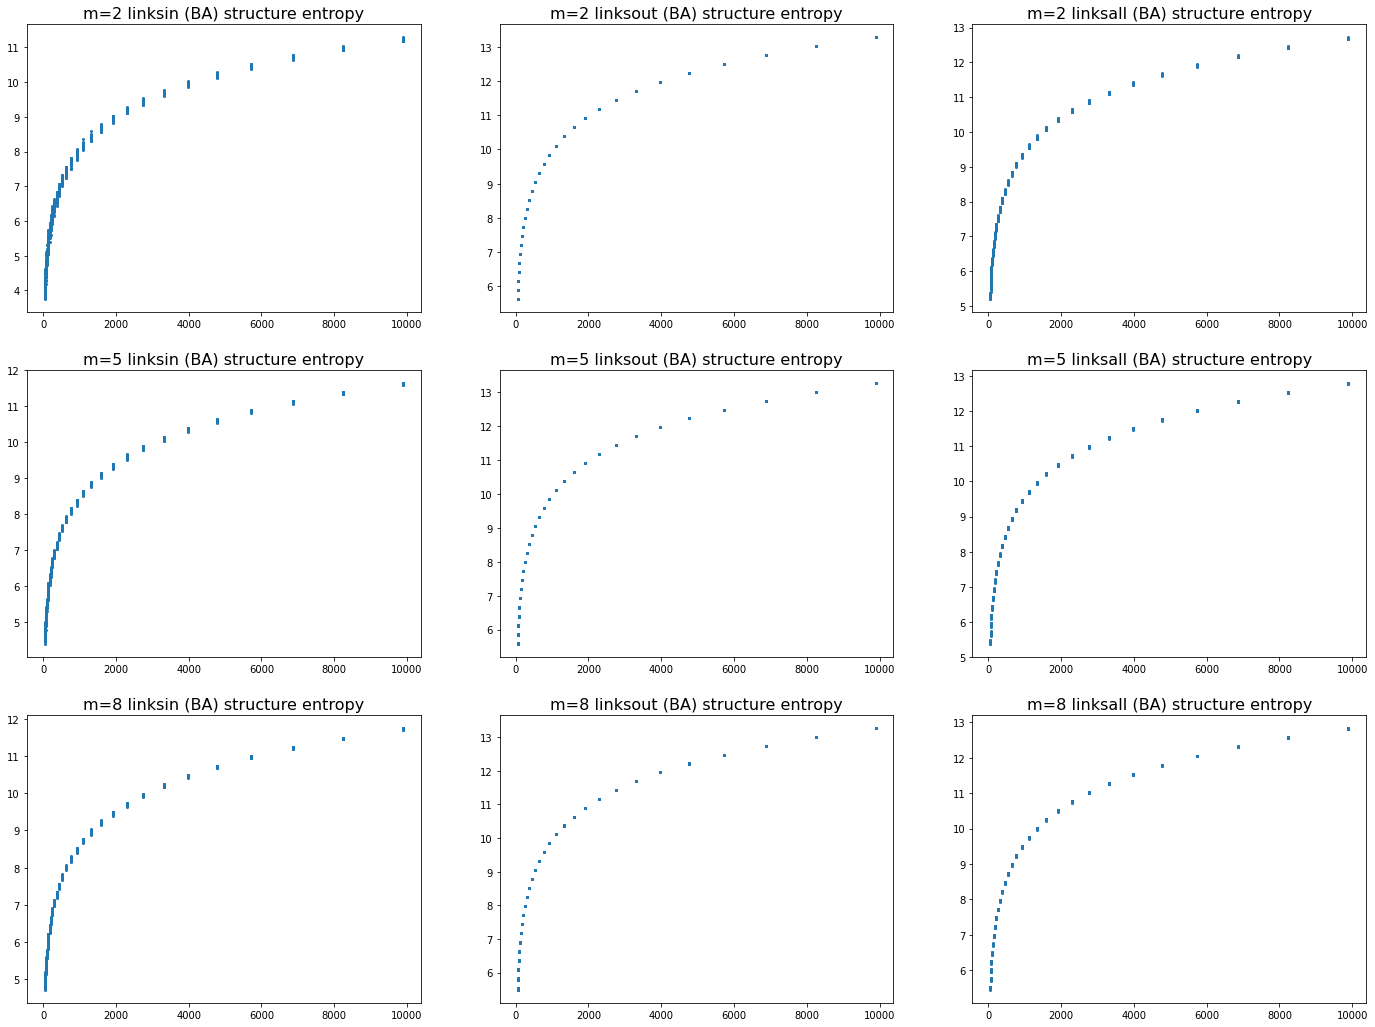

In [36]:
a = [item[1][3:] for item in iterator_ret_data(ret_2)]
b = [item[1][3:] for item in iterator_ret_data(ret_5)]
c = [item[1][3:] for item in iterator_ret_data(ret_8)]
draw_trend(a,b,c,"(BA) structure")
# a
